In [6]:
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from datetime import datetime
import cv2
from PIL import Image
from keras import backend, optimizers
import sys

In [7]:
import tensorflow as tf
tf.test.gpu_device_name()
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7770204656780818801
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14626652160
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1217729438713889986
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [8]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K

In [9]:

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)


def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [10]:
def conv_block(x, filter_size, size, dropout, batch_norm=False):

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv

In [11]:
def UNet(input_shape, NUM_CLASSES=1, dropout_rate=0.2, batch_norm=True):
    '''
    UNet,

    '''
    # network structure
    FILTER_NUM = 64 # number of filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters


    inputs = layers.Input(input_shape, dtype=tf.float32)

    # Downsampling layers
    # DownRes 1, convolution + pooling
    conv_128 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers

    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, conv_16], axis=3)
    up_conv_16 = conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7

    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, conv_32], axis=3)
    up_conv_32 = conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8

    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, conv_64], axis=3)
    up_conv_64 = conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9

    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, conv_128], axis=3)
    up_conv_128 = conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers

    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model
    model = models.Model(inputs, conv_final, name="UNet")
    print(model.summary())
    return model


In [12]:
input_shape = (256,256,3)
UNet(input_shape, NUM_CLASSES=1, dropout_rate=0.2, batch_norm=True)

Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['batch_normalization[0][0]

Mounted at /content/drive
TRAIN IMG_DIR /content/drive/MyDrive/Dataset/images/ 
 TRAIN MSK_DIR /content/drive/MyDrive/Dataset/masks/ 



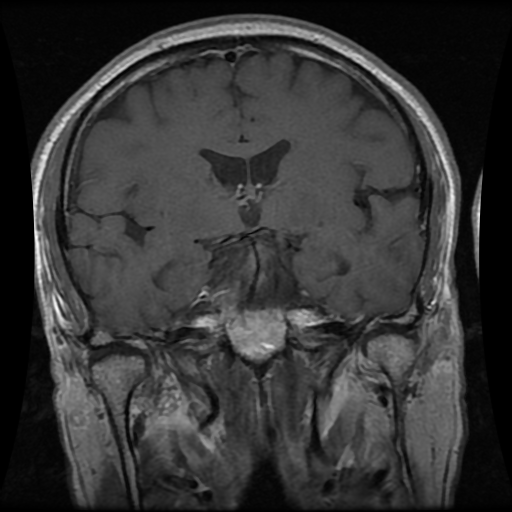

In [13]:
import os
from google.colab.patches import cv2_imshow
from google.colab import drive
drive.mount('/content/drive')

DATA_DIR = '/content/drive/MyDrive/Dataset'

image_directory = os.path.join(DATA_DIR, 'images/')
mask_directory = os.path.join(DATA_DIR, 'masks/')

SIZE = 256
print("TRAIN IMG_DIR", image_directory, "\n", "TRAIN MSK_DIR", mask_directory, "\n",)

# checking if image is successfully loaded or not

if not os.path.exists(image_directory):
    print("Directory does not exist:", image_directory)

for image_name in os.listdir(image_directory):
    file_path = os.path.join(image_directory, image_name)
    if not os.path.isfile(file_path):
        print("File does not exist:", file_path)

for image_name in os.listdir(image_directory):
    file_path = os.path.join(image_directory, image_name)
    image = cv2.imread(file_path, 1)
    if image is None:
        print("Failed to read image:", file_path)
if image is not None:
    # Display the image using cv2_imshow()
    cv2_imshow(image)
else:
    print("Failed to load image:", file_path)


In [14]:
image_dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.
images = sorted(os.listdir(image_directory))
for i, image_name in enumerate(images):
    if i > 500:
        break
    # Construct the full path to the image file
    image_path = os.path.join(image_directory, image_name)
    # Read the image using OpenCV
    image = cv2.imread(image_path, 1)
    # Resize the image using OpenCV
    image = cv2.resize(image, (SIZE, SIZE))
    # Append the resized image to the dataset
    image_dataset.append(np.array(image))

In [15]:
mask_dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.
images = sorted(os.listdir(mask_directory))
for i, image_name in enumerate(images):
    if i > 500:
        break
    # Construct the full path to the image file
    image_path = os.path.join(mask_directory, image_name)
    # Read the image using OpenCV
    image = cv2.imread(image_path, 0)
    # Resize the image using OpenCV
    image = cv2.resize(image, (SIZE, SIZE))
    # Append the resized image to the dataset
    mask_dataset.append(np.array(image))

In [16]:
#Normalize images
image_dataset = np.array(image_dataset)/255
#D not normalize masks, just rescale to 0 to 1.
#mask_image = np.expand_dims((np.array(image_dataset)),3) /255
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255

type(image_dataset)

type(mask_dataset)
print(image_dataset.shape)
print(mask_dataset.shape)

(501, 256, 256, 3)
(501, 256, 256, 1)


(450, 256, 256, 3)
(51, 256, 256, 3)
(450, 256, 256, 1)
(51, 256, 256, 1)


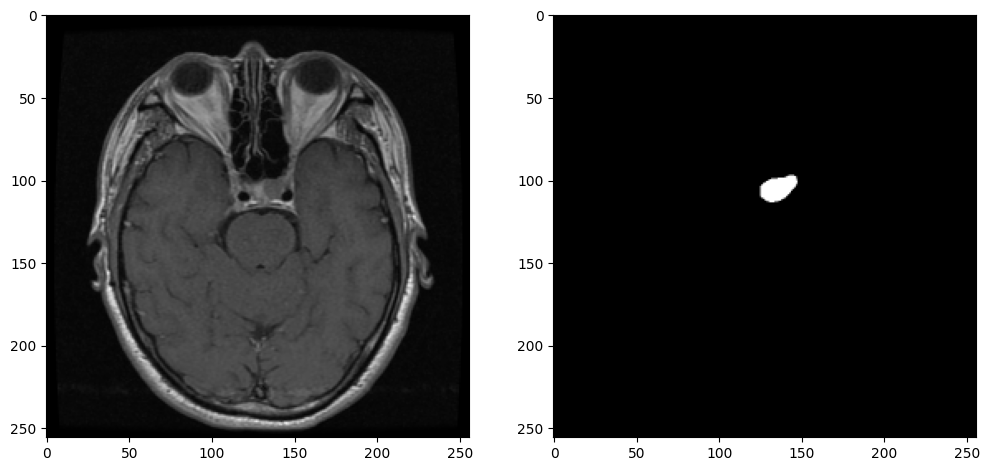

In [17]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size=0.10, random_state=0)

# Print the shapes of training and testing sets to verify()
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

# Generate a random image number within the range of the testing set
image_number = random.randint(0, len(X_test)-1)

# Display the random image and its corresponding mask
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_test[image_number], (256, 256, 3)), cmap='gray')  # Assuming images are 256x256x3
plt.subplot(122)
plt.imshow(np.reshape(y_test[image_number], (256, 256)), cmap='gray')    # Displaying the grayscale mask
plt.show()


In [18]:
!pip install focal_loss

In [19]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3];
#X_train.shape returns a tuple (500, 256, 256, 3)
num_labels = 1; #binary classification
input_shape = [IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS]
batch_size = 8

from focal_loss import BinaryFocalLoss
print(input_shape)

[256, 256, 3]


In [20]:
unet_model = UNet(input_shape)

unet_model.compile(optimizer=Adam(learning_rate = 1e-2), loss=BinaryFocalLoss(gamma=2),
              metrics=['accuracy', jacard_coef])


print(unet_model.summary())
start1 = datetime.now()
unet_history = unet_model.fit(X_train, y_train,
                    verbose=1,
                    batch_size = batch_size,
                    validation_data=(X_test, y_test ),
                    shuffle=False,
                    epochs=100)

stop1 = datetime.now()
#Execution time of the model
execution_time_Unet = stop1-start1
print("UNet execution time is: ", execution_time_Unet)




Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 256, 256, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_19 (Ba  (None, 256, 256, 64)         256       ['conv2d_19[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_19 (Activation)  (None, 256, 256, 64)         0         ['batch_normalization_19[0]

In [21]:
unet_model.save('UNet_Model_save.hdf5')
%cp UNet_Model_save.hdf5 /content/drive/MyDrive/Dataset/UNet_Model_save.hdf5

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model_path = "/content/drive/MyDrive/Dataset/UNet_Model_save.hdf5"
model = tf.keras.models.load_model(model_path, compile=False)

import random
test_img_number = random.randint(0, X_test.shape[0]-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]

prediction = (model.predict(np.expand_dims(test_img, 0))[0] > 0.5).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

#IoU for a single image
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(ground_truth[:,:,0], prediction)
print("Mean IoU =", IOU_keras.result().numpy())
print("ground_truth", test_img_number, type(ground_truth[:,:,0]), len(ground_truth[:,:,0]), ground_truth[:,:,0].shape)
print("prediction::", type(prediction), len(prediction), prediction.shape)

import pandas as pd

IoU_Values = []

for img in range(0,X_test.shape[0]):
  temp_img = X_test[img]
  ground_truth = y_test[img]
  prediction = (model.predict(np.expand_dims(temp_img, 0))[0] > 0.5).astype(np.uint8)

  # Plot each image, mask and prediction
  plt.figure(figsize=(16, 8))
  plt.subplot(231)
  plt.title('Testing Image')
  plt.imshow(temp_img, cmap='gray')
  plt.subplot(232)
  plt.title('Testing Label')
  plt.imshow(ground_truth[:,:,0], cmap='gray')
  plt.subplot(233)
  plt.title('Prediction on test image')
  plt.imshow(prediction, cmap='gray')

  plt.show()

  IoU = MeanIoU(num_classes=n_classes)
  IoU.update_state(ground_truth[:,:,0], prediction)
  IoU = IoU.result().numpy()
  IoU_Values.append(IoU)

  print(IoU)

df = pd.DataFrame(IoU_Values, columns = ["IoU"])
df = df[df.IoU != 1.0]

mean_IoU = df.mean().values
print("Mean IoU value for this dataset is : ", mean_IoU)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import pandas as pd
unet_history_df = pd.DataFrame(unet_history.history)
with open('unet_history_df.csv', mode='w') as f:
    unet_history_df.to_csv(f)

In [ ]:
#######################################################################
#Check history plots, one model at a time
history = unet_history
print("unet_history plot: ")
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

#plt.savefig('Training_and_validation_loss.png')
save_path1 = '/content/drive/MyDrive/Dataset/Training_and_validation_loss.png'

# Save the figure
plt.savefig(save_path1)
plt.show()


acc = history.history['jacard_coef']
#acc = history.history['accuracy']
val_acc = history.history['val_jacard_coef']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Jacard')
plt.plot(epochs, val_acc, 'r', label='Validation Jacard')
plt.title('Training and validation Jacard')
plt.xlabel('Epochs')
plt.ylabel('Jacard')
plt.legend()

#plt.savefig('Training_and_validation_Jacard.png')
save_path2 = '/content/drive/MyDrive/Dataset/Training_and_validation_jacard.png'

# Save the figure
plt.savefig(save_path2)
plt.show()